In [24]:
##Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt




##Read first CSV File
dataFile1 = pd.read_csv("out_1.csv")
##Read second CSV File
dataFile2 = pd.read_csv("out_2.csv")

#Add Zone columns
dataFile1['zone']='1'
dataFile2['zone']='2'

#Append File 2 to File 1
mergedDataFile = dataFile1.append(dataFile2)

#Add Energy in KJ column formula(KE=1/2mv^2)/1000 in m = kg and v = m/s
mergedDataFile['energy']=((mergedDataFile['mass']/2)*(mergedDataFile['velocity']**2) / 1000)

mergedDataFile



#mergedDataFile.boxplot()
#print(mergedDataFile)
#print(mergedDataFile['zone'])


,date,timestamp,mass,velocity,zone,energy
0,2019-01-01,09:00,194,8.4,1,6.844320
1,2019-01-01,21:00,224,8.8,1,8.673280
2,2019-01-02,14:00,3104,9.2,1,131.361280
3,2019-01-04,15:00,228,8.0,1,7.296000
4,2019-01-05,23:00,755,7.0,1,18.497500
...,...,...,...,...,...,...
27,2019-03-20,10:00,16,42.1,2,14.179280
28,2019-03-21,13:00,211,29.0,2,88.725500
29,2019-03-24,16:00,3,42.3,2,2.683935
30,2019-03-25,14:00,63,43.2,2,58.786560


In [25]:
# Add Trigger if stone has fallen
mergedDataFile["Trigger"] = np.where(mergedDataFile["zone"] == 0, 0, 1) 

In [26]:
# Create Datetime Column
mergedDataFile["DateTime"] = pd.to_datetime(mergedDataFile['date'] + ' ' + mergedDataFile['timestamp'])

In [27]:
# Change Hour if two stones at same time
mergedDataFile = mergedDataFile.sort_values(by=['DateTime'])
mergedDataFile = mergedDataFile.reset_index(drop=True)
mergedDataFile.loc[1, 'timestamp'] = "10:00"
mergedDataFile.loc[44, 'timestamp'] = "13:00"
mergedDataFile.loc[89, 'timestamp'] = "13:00"

In [28]:
# Update Datetime Column
mergedDataFile["DateTime"] = pd.to_datetime(mergedDataFile['date'] + ' ' + mergedDataFile['timestamp'])

In [29]:
# Fill missing hours
dfTimeSerie = mergedDataFile
dfTimeSerie = dfTimeSerie.set_index(mergedDataFile["DateTime"])
dfTimeSerie = dfTimeSerie.resample('H').first().fillna(0)
dfTimeSerie['DateTime'] = dfTimeSerie.index

In [30]:
# Fill new missing days and hours in date and timestamp
dfTimeSerie["date"] = dfTimeSerie["DateTime"].dt.date
dfTimeSerie["timestamp"] = dfTimeSerie["DateTime"].dt.time

In [31]:
# Rolling 24h
dfTimeSerie["rollingEnergy24h"] = dfTimeSerie["energy"].rolling(24, min_periods=1).sum()
dfTimeSerie["rollingmass24h"] = dfTimeSerie["mass"].rolling(24, min_periods=1).sum()

In [32]:
# Calculate Breach
dfTimeSerie["BreachEnergy"] = np.where(dfTimeSerie["energy"] >= 1000, 1, 0)
dfTimeSerie["BreachFullNet"] = np.where((dfTimeSerie["energy"] >= 500) & (dfTimeSerie["rollingmass24h"] >= 2000), 1, 0)
# Theoretisch müsste man dfTimeSerie["rollingmass24h"] von der Reihe darüber nehmen, nun wird auch der neue Stein dazugezählt.

In [33]:
Uebersicht = mergedDataFile.describe()
Uebersicht

,mass,velocity,energy,Trigger
count,100.000000,100.00000,100.000000,100.0
mean,459.230000,18.06900,40.045909,1.0
std,626.671742,14.02409,60.222295,0.0
min,0.000000,3.60000,0.000000,1.0
25%,76.750000,8.37500,9.354381,1.0
50%,232.000000,10.05000,18.868720,1.0
75%,509.750000,32.52500,46.895130,1.0
max,3104.000000,46.50000,394.796430,1.0


In [34]:
# Übersicht über Energie, Zonen und kombiniert
dfTimeSerie["UebersichtEnergie"] = pd.cut(dfTimeSerie.energy, [0, 50, 150, 300, np.inf], labels=["Klein", "Mittel", "Gross", "Sehr gross"])
UebersichtEnergie = pd.pivot_table(dfTimeSerie, values='Trigger', columns=['UebersichtEnergie'], aggfunc=np.sum)
UebersichtZone = pd.pivot_table(dfTimeSerie, values='Trigger', columns=['zone'], aggfunc=np.sum)
UebersichtZoneEnergie = pd.pivot_table(dfTimeSerie, values='Trigger', columns=['zone', 'UebersichtEnergie'], aggfunc=np.sum)
## Achtung: ein Stein hat Energie 0 ##
UebersichtEnergie

UebersichtEnergie,Klein,Mittel,Gross,Sehr gross
Trigger,76.0,17.0,5.0,1.0


In [35]:
UebersichtZone

zone,0,1,2
Trigger,0.0,68.0,32.0


In [36]:
UebersichtZoneEnergie

zone                  1                  2                        
UebersichtEnergie Klein Mittel Gross Klein Mittel Gross Sehr gross
Trigger            57.0   10.0   1.0  19.0    7.0   4.0        1.0

<AxesSubplot:title={'center':'mass'}, xlabel='zone'>

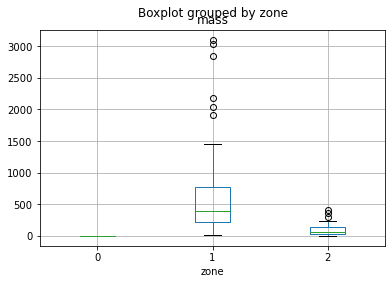

In [37]:
dfTimeSerie.boxplot(column = "mass", by = "zone")

<AxesSubplot:title={'center':'velocity'}, xlabel='zone'>

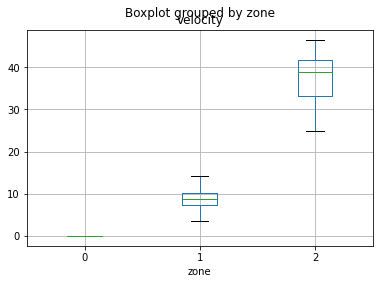

In [38]:
dfTimeSerie.boxplot(column = "velocity", by = "zone")

<AxesSubplot:title={'center':'energy'}, xlabel='zone'>

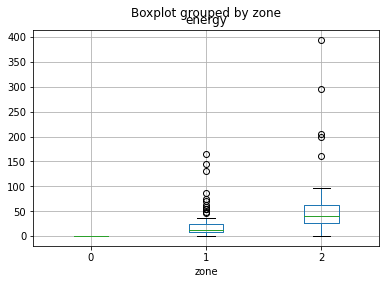

In [39]:
dfTimeSerie.boxplot(column = "energy", by = "zone")

<AxesSubplot:title={'center':'mass'}, xlabel='UebersichtEnergie'>

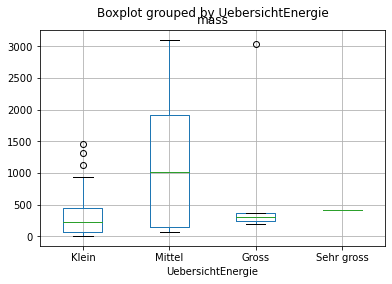

In [40]:
dfTimeSerie.boxplot(column = "mass", by = "UebersichtEnergie")

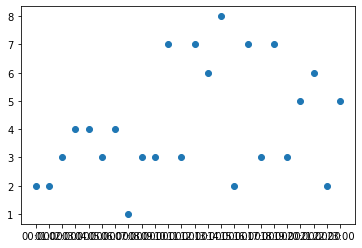

In [41]:
# X-Achse: Uhrzeit 0:00 - 24:00
ScatterplotTime = mergedDataFile.groupby(['timestamp']).agg({'Trigger':'sum'})
plt.scatter(ScatterplotTime.index, ScatterplotTime['Trigger'])

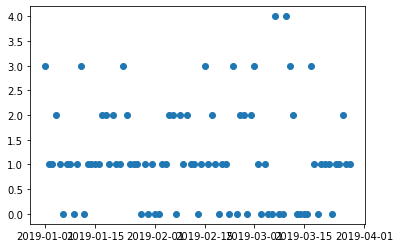

In [42]:
ScatterplotDate = dfTimeSerie.groupby(['date']).agg({'Trigger':'sum'})
plt.scatter(ScatterplotDate.index, ScatterplotDate['Trigger'])

<AxesSubplot:ylabel='Frequency'>

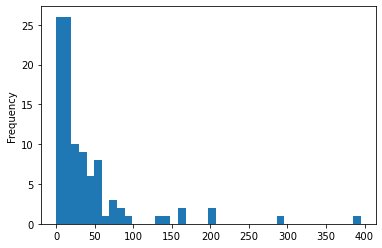

In [43]:
mergedDataFile["energy"].plot.hist(bins = 40)

<AxesSubplot:ylabel='Frequency'>

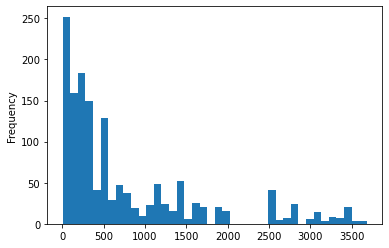

In [44]:
dfTimeSerieHisto = dfTimeSerie[dfTimeSerie.rollingmass24h != 0]
dfTimeSerieHisto["rollingmass24h"].plot.hist(bins = 40)

<AxesSubplot:xlabel='date'>

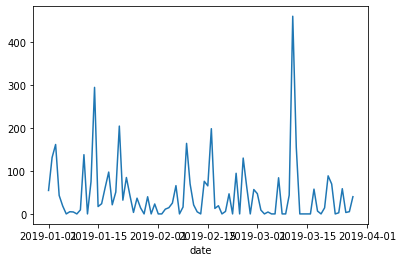

In [45]:
dfTimeSerie.groupby(dfTimeSerie["date"]).sum()["energy"].plot()

<AxesSubplot:xlabel='DateTime'>

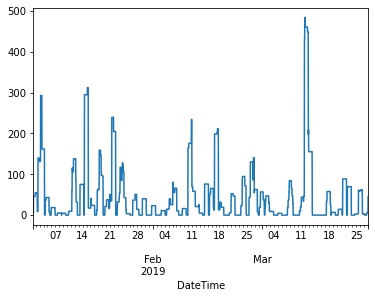

In [46]:
dfTimeSerie["rollingEnergy24h"].plot()

<AxesSubplot:xlabel='DateTime'>

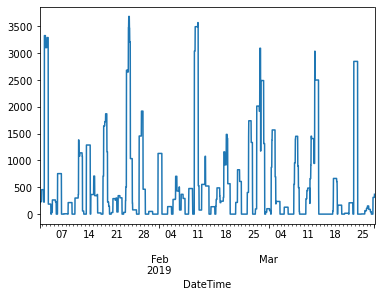

In [47]:
dfTimeSerie["rollingmass24h"].plot()

<AxesSubplot:xlabel='DateTime'>

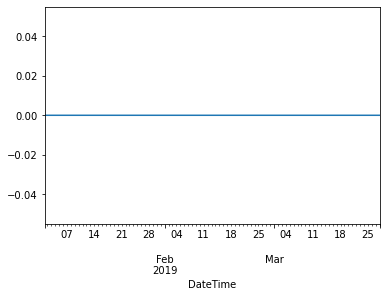

In [48]:
dfTimeSerie["BreachEnergy"].plot()

<AxesSubplot:xlabel='DateTime'>

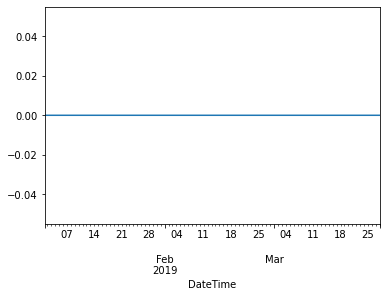

In [49]:
dfTimeSerie["BreachFullNet"].plot()